In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#Imports
import numpy as np
import tensorflow as tf
#from tensorflow import layers
#from tensorflow.python.layers.convolutional import conv2d 
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
import glob
from scipy import misc

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

#if __name__=="__main__":
 #   tf.app.run()

In [22]:
def cnn_model_fn(features,labels,mode):
    #input layer
    input_layer=tf.reshape(features,[-1,128,128,3])
    
    #Convolutional layer 1 
    conv1=tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[5,5],
    padding="same",
    activation=tf.nn.relu)
    
    #pooling layer - change pool size later
    pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2],strides=2)
    
    #Convolutional layer 2
    conv2=tf.layers.conv2d(
    inputs=pool1,
    filters=16,
    kernel_size=[5,5],
    padding="same",
    activation=tf.nn.relu)
    
    #pooling layer - change pool size later
    pool2=tf.layers.max_pooling2d(inputs=conv2,pool_size=[2,2],strides=2)
    
    #Convolutional layer 3
    conv3=tf.layers.conv2d(
    inputs=input_layer,
    filters=4,
    kernel_size=[5,5],
    padding="same",
    activation=tf.nn.relu)
    
    #pooling layer - change pool size later
    pool3=tf.layers.max_pooling2d(inputs=conv3,pool_size=[2,2],strides=2)
    
    #Dense layer
    # Dense Laye
    pool3_flat = tf.reshape(pool3, [-1, 64 * 64 * 4])
    dense1 = tf.layers.dense(inputs=pool3_flat, units=256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units=128, activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2, units=64, activation=tf.nn.relu)
    dense4 = tf.layers.dense(inputs=dense3, units=32, activation=tf.nn.relu)
    dense5 = tf.layers.dense(inputs=dense4, units=16, activation=tf.nn.relu)
    dense6 = tf.layers.dense(inputs=dense5, units=8, activation=tf.nn.relu)
    dense7 = tf.layers.dense(inputs=dense6, units=4, activation=tf.nn.relu)
    dense8 = tf.layers.dense(inputs=dense7, units=2, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense8, rate=0.4, training=mode == learn.ModeKeys.TRAIN)

      # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    loss = None
    train_op = None

      # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
        loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.01,
        optimizer="SGD")

    # Generate Predictions
    predictions = {
      "classes": tf.argmax(
          input=logits, axis=1),
      "probabilities": tf.nn.softmax(
          logits, name="softmax_tensor")
  }
    

    # Return a ModelFnOps object
    return model_fn_lib.ModelFnOps(
          mode=mode, predictions=predictions, loss=loss, train_op=train_op)
    

    
    


In [23]:
def main(unused_argv):
    images_train=[]
    output_train=[]
    directory='/home/ubuntu/Data/'
    for image_path in glob.glob(directory+"*.png"):
        currentimage = misc.imread(image_path)
        currentresize = misc.imresize(currentimage,(128,128))
        if 'Building' in image_path:
            images_train.append(currentresize)
            output_train.append(np.array(1))
        else:
            images_train.append(currentresize)
            output_train.append(np.array(0))
        
    images_np_array_train = np.float32(np.array(images_train))
    output_np_array_train = np.float32(np.array(output_train))
    
    images_test=[]
    output_test=[]
    directory='/home/ubuntu/Test/'
    for image_path in glob.glob(directory+"*.png"):
        currentimage = misc.imread(image_path)
        currentresize = misc.imresize(currentimage,(128,128))
        if 'Building' in image_path:
            images_test.append(currentresize)
            output_test.append(np.array(1))
        else:
            images_test.append(currentresize)
            output_test.append(np.array(0))
    #plt.imshow(images_test[0])
    images_np_array_test = np.float32(np.array(images_test))
    output_np_array_test = np.float32(np.array(output_test))
   
    #creating a estimator
    classifier=learn.Estimator(model_fn=cnn_model_fn)
    #logging
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    classifier.fit(x=images_np_array_train,y=output_np_array_train,batch_size=25,steps=10000,monitors=[logging_hook])
    #Accuracy
    metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes"),}
    eval_results=classifier.evaluate(
    x=images_np_array_test,y=output_np_array_test,metrics=metrics)
    print(eval_results)
    
if __name__=="__main__":
    tf.app.run()




INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_environment': 'local', '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_master': '', '_is_chief': True, '_tf_random_seed': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3f5a8e1da0>, '_task_type': None, '_task_id': 0, '_save_summary_steps': 100}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y 

/usr/local/lib/python3.4/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpiwkyc46k/model.ckpt.
INFO:tensorflow:step = 1, loss = 0.693147
INFO:tensorflow:probabilities = [[ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]]
INFO:tensorflow:probabilities = [[ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.57358372]
 [ 0.42641625  0.

SystemExit: 

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
mnist = learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [35]:
images_test=[]
output_test=[]
directory='/home/ubuntu/Test/'
for image_path in glob.glob(directory+"*.png"):
    currentimage = misc.imread(image_path,mode='L')
    currentresize = misc.imresize(currentimage,(128,128))
    if 'Building' in image_path:
        images_test.append(currentresize)
        output_test.append(np.array(0))
    else:
        images_test.append(currentresize)
        output_test.append(np.array(1))
    #plt.imshow(images_test[0])

images_np_array_test = np.float32(np.array(images_test))
output_np_array_test = np.float32(np.array(output_test))

In [36]:
images_np_array_test.shape

(34, 128, 128)

In [37]:
#REading images and assigning for train
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ni
import scipy.misc as mi
from PIL import Image
from scipy import misc
import glob
images_train=[]
output_train=[]
directory='/home/ubuntu/Data/'
for image_path in glob.glob(directory+"*.png"):
    currentimage = misc.imread(image_path)
    currentresize = misc.imresize(currentimage,(128,128))
    if 'Building' in image_path:
        images_train.append(currentresize)
        output_train.append(np.array(1))
    else:
        images_train.append(currentresize)
        output_train.append(np.array(0))
        
images_np_array_train = np.float32(np.array(images_train))
output_np_array_train = np.float32(np.array(output_train))

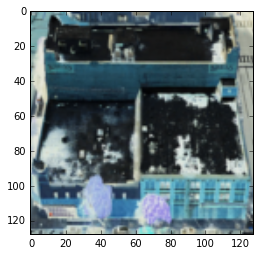

In [38]:
plt.imshow(images_np_array_train[0])

In [39]:
#REading images and assigning for train
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ni
import scipy.misc as mi
from PIL import Image
from scipy import misc
import glob
images_train=[]
output_train=[]
directory='/home/ubuntu/Test/'
for image_path in glob.glob(directory+"*.png"):
    currentimage = misc.imread(image_path)
    currentresize = misc.imresize(currentimage,(128,128))
    if 'Building' in image_path:
        images_train.append(currentresize)
        output_train.append(np.array(1))
    else:
        images_train.append(currentresize)
        output_train.append(np.array(0))
        
images_np_array_train = np.float32(np.array(images_train))
output_np_array_train = np.float32(np.array(output_train))

In [40]:
images_np_array_train.shape

(34, 128, 128, 3)

In [17]:
input_layer=images_np_array_train[1].shape

In [42]:
input_layer=tf.reshape(images_np_array_train,[-1,128,128,3])
    
#Convolutional layer 1 
conv1=tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
    
#pooling layer - change pool size later
pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=[2,2],strides=2)
    
#Convolutional layer 2
conv2=tf.layers.conv2d(inputs=pool1,filters=16,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
    
#pooling layer - change pool size later
pool2=tf.layers.max_pooling2d(inputs=conv2,pool_size=[2,2],strides=2)
    
#Convolutional layer 3
conv3=tf.layers.conv2d(inputs=input_layer,filters=4,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
    
#pooling layer - change pool size later
pool3=tf.layers.max_pooling2d(inputs=conv3,pool_size=[2,2],strides=2)
pool3_flat = tf.reshape(pool3, [-1, 64 * 64 * 4])
dense1 = tf.layers.dense(inputs=pool3_flat, units=256, activation=tf.nn.relu)
dense2 = tf.layers.dense(inputs=dense1, units=32, activation=tf.nn.relu)
dense3 = tf.layers.dense(inputs=dense2, units=16, activation=tf.nn.relu)
dense4 = tf.layers.dense(inputs=dense3, units=8, activation=tf.nn.relu)
dense5 = tf.layers.dense(inputs=dense4, units=4, activation=tf.nn.relu)
dense6 = tf.layers.dense(inputs=dense5, units=2, activation=tf.nn.relu)
    

In [43]:
dense6

<tf.Tensor 'dense_6/Relu:0' shape=(34, 2) dtype=float32>